In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import glob
import json
import warnings
import random

# Tắt cảnh báo
warnings.filterwarnings('ignore')

# Cấu hình Pandas để in ra HẾT CÁC CỘT (Không bị ...)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Thiết lập Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Cấu hình thiết bị
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- CẤU HÌNH HYPERPARAMETERS ---
SEQ_LEN = 30
HIDDEN_DIM = 128
DROPOUT = 0.2
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# --- CẤU HÌNH ĐƯỜNG DẪN ---
PRICE_DIR = "../../DATASET/PRICE"
SENTIMENT_DIR = "../../DATASET/SENTIMENT"
LOG_DIR = "../../LOGS"

os.makedirs(LOG_DIR, exist_ok=True)
print(f" Thư mục LOGS: {os.path.abspath(LOG_DIR)}")

Using device: cpu
 Thư mục LOGS: d:\NghienCuu\NCT3\LOGS


In [22]:
class SentimentDLinearNodeModel(nn.Module):
    def __init__(self, seq_len=30, price_dim=5, sentiment_dim=10, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.price_dim = price_dim
        self.sentiment_dim = sentiment_dim
        
        # DLinear cho Price
        self.price_decomp = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len)
        )
        
        # DLinear cho Sentiment
        self.sentiment_decomp = nn.Sequential(
            nn.Linear(seq_len, hidden_dim // 2),
            nn.ReLU(), 
            nn.Linear(hidden_dim // 2, seq_len)
        )
        
        # NODE (Neural ODE)
        self.node_layers = nn.Sequential(
            nn.Linear(price_dim + sentiment_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, price_dim + sentiment_dim)
        )
        
        # Predictor
        self.predictor = nn.Sequential(
            nn.Linear((price_dim + sentiment_dim) * seq_len, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, price_x, sentiment_x):
        batch_size, seq_len, _ = price_x.shape
        combined_input = torch.cat([price_x, sentiment_x], dim=-1)
        
        price_trend = self.price_decomp(price_x.transpose(1, 2)).transpose(1, 2)
        sentiment_trend = self.sentiment_decomp(sentiment_x.transpose(1, 2)).transpose(1, 2)
        combined_trend = torch.cat([price_trend, sentiment_trend], dim=-1)
        
        node_output = combined_input + self.node_layers(combined_input)
        final_features = combined_trend + node_output
        
        flattened = final_features.reshape(batch_size, -1)
        output = self.predictor(flattened)
        return output

In [23]:
class DataProcessor:
    def __init__(self):
        self.price_scalers = {}
        self.sentiment_scalers = {}
        self.feature_scalers = {}
        
    def load_and_merge_data(self, price_path, sentiment_path):
        """
        Load file và Merge theo nguyên tắc:
        1. Lấy Price làm gốc (Left Join).
        2. Loại bỏ dòng không có Price (Close bị NaN).
        """
        try:
            # Load raw
            price_df = pd.read_csv(price_path, encoding='utf-8-sig')
            sentiment_df = pd.read_csv(sentiment_path, encoding='utf-8-sig')
            
            # Rename columns
            map_cols = {'Ngày': 'Date', 'Lần cuối': 'Close', 'Mở': 'Open', 'Cao': 'High', 'Thấp': 'Low', 'KL': 'Volume'}
            price_df = price_df.rename(columns=map_cols)
            sentiment_df = sentiment_df.rename(columns=map_cols)

            # Parse Date
            price_df['Date'] = pd.to_datetime(price_df['Date'], errors='coerce')
            sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], errors='coerce')
            
            # --- BƯỚC 1: LỌC SẠCH PRICE ---
            # Chỉ giữ dòng có Date và Close hợp lệ
            price_df = price_df.dropna(subset=['Date', 'Close']).sort_values('Date')
            sentiment_df = sentiment_df.dropna(subset=['Date']).sort_values('Date')

            print(f"\n THỐNG KÊ FILE GỐC:")
            print(f"   1. Price     : {len(price_df):6d} dòng | {price_df['Date'].min().date()} -> {price_df['Date'].max().date()}")
            print(f"   2. Sentiment : {len(sentiment_df):6d} dòng | {sentiment_df['Date'].min().date()} -> {sentiment_df['Date'].max().date()}")

            # --- BƯỚC 2: MERGE (LEFT JOIN) ---
            # Chỉ lấy ngày có trong Price. Nếu Sentiment không có ngày đó -> NaN.
            # Nếu Sentiment có ngày mà Price không có -> Bị loại bỏ.
            merged_df = pd.merge(price_df, sentiment_df, on='Date', suffixes=('', '_sentiment'), how='left')

            # --- BƯỚC 3: CHECK LẠI ---
            # Đảm bảo tuyệt đối không có dòng nào mất giá Close
            merged_df = merged_df.dropna(subset=['Close'])

            # Clean numeric columns
            for col in ['Close', 'Open', 'High', 'Low']:
                if col in merged_df.columns and merged_df[col].dtype == object:
                    merged_df[col] = pd.to_numeric(merged_df[col].str.replace(',', ''), errors='coerce')

            print(f"   3. SAU MERGE : {len(merged_df):6d} dòng (Đã loại bỏ các dòng chỉ có Sentiment)")
            
            return merged_df

        except Exception as e:
            print(f" Lỗi xử lý file: {e}")
            return None

    def create_features(self, df):
        """Tạo Features"""
        # 1. Price Features
        price_feats = pd.DataFrame()
        price_feats['close'] = df['Close']
        price_feats['open'] = df['Open']
        price_feats['high'] = df['High']
        price_feats['low'] = df['Low']
        price_feats['volume'] = pd.to_numeric(df['Volume'], errors='coerce').fillna(0) if 'Volume' in df.columns else 1000000
        price_feats = price_feats.fillna(method='bfill').fillna(0)

        # 2. Sentiment Features (Lấy hết các cột có thể có)
        sent_feats = pd.DataFrame()
        # List các cột tiềm năng trong file sentiment
        target_cols = ['sentiment_score', 'impact_score', 'relevance_score', 'confidence', 'short_term_score', 'medium_term_score']
        
        for col in target_cols:
            if col in df.columns:
                sent_feats[col] = pd.to_numeric(df[col], errors='coerce')
            else:
                sent_feats[col] = 0.0
        
        # 3. Feature Engineering (Tính toán trên sentiment_score đã merge)
        if 'sentiment_score' in sent_feats.columns:
            sent_feats['sentiment_momentum'] = sent_feats['sentiment_score'].rolling(5).mean()
            sent_feats['sentiment_volatility'] = sent_feats['sentiment_score'].rolling(10).std()
            sent_feats['sentiment_trend'] = sent_feats['sentiment_score'].diff()
        
        sent_feats = sent_feats.fillna(0)
        
        # Clip & Normalize
        for col in sent_feats.columns:
            sent_feats[col] = np.clip(sent_feats[col], -3, 3) / 3

        return price_feats, sent_feats, df['Close'].values

    def prepare_sequences(self, price_feats, sent_feats, prices, stock_name, seq_len=30):
        # Scale Price
        price_key = f"{stock_name}_price"
        self.price_scalers[price_key] = StandardScaler()
        price_scaled = self.price_scalers[price_key].fit_transform(price_feats)
        
        # Scale Sentiment
        sent_key = f"{stock_name}_sentiment"
        self.sentiment_scalers[sent_key] = StandardScaler()
        sent_scaled = self.sentiment_scalers[sent_key].fit_transform(sent_feats)
        
        # Scale Target
        target_key = f"{stock_name}_target"
        self.feature_scalers[target_key] = StandardScaler()
        prices_scaled = self.feature_scalers[target_key].fit_transform(prices.reshape(-1, 1)).flatten()
        
        X_price, X_sent, y = [], [], []
        min_len = min(len(price_scaled), len(sent_scaled))
        
        for i in range(seq_len, min_len):
            X_price.append(price_scaled[i-seq_len:i])
            X_sent.append(sent_scaled[i-seq_len:i])
            y.append(prices_scaled[i])
            
        return np.array(X_price), np.array(X_sent), np.array(y)

In [24]:
def train_model(model, train_loader, val_loader, stock_name, epochs=150):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
    criterion = nn.MSELoss()
    
    best_r2 = -float('inf')
    patience = 20; patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_r2': []}
    save_path = os.path.join(LOG_DIR, f'{stock_name}_best_sentiment_model.pt')
    
    print(f" Bắt đầu training {stock_name}...")
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for p, s, y in train_loader:
            p, s, y = p.to(DEVICE), s.to(DEVICE), y.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            loss = criterion(model(p, s), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_losses.append(loss.item())
            
        model.eval()
        val_losses = []; preds = []; targets = []
        with torch.no_grad():
            for p, s, y in val_loader:
                p, s, y = p.to(DEVICE), s.to(DEVICE), y.to(DEVICE).unsqueeze(1)
                out = model(p, s)
                val_losses.append(criterion(out, y).item())
                preds.extend(out.cpu().numpy().flatten())
                targets.extend(y.cpu().numpy().flatten())
        
        avg_train = np.mean(train_losses)
        avg_val = np.mean(val_losses)
        r2 = r2_score(targets, preds)
        
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)
        history['val_r2'].append(r2)
        scheduler.step(r2)
        
        status = ""
        if r2 > best_r2:
            best_r2 = r2
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            status = " NEW BEST"
        else:
            patience_counter += 1
            
        if epoch % 10 == 0 or status:
            print(f"Epoch {epoch:3d} | Loss: {avg_train:.5f} | Val R2: {r2:.4f} {status}")
            
        if patience_counter >= patience:
            print(f" Early stopping tại epoch {epoch}")
            break
            
    print(f" Kết thúc. Best R2: {best_r2:.4f}")
    return history, save_path

def visualize_prediction(model, processor, price_feats, sent_feats, targets, stock_name):
    # Scale inputs
    price_key = f"{stock_name}_price"
    sent_key = f"{stock_name}_sentiment"
    target_key = f"{stock_name}_target"
    
    p_scaled = processor.price_scalers[price_key].transform(price_feats)
    s_scaled = processor.sentiment_scalers[sent_key].transform(sent_feats)
    
    X_p, X_s = [], []
    if len(p_scaled) < SEQ_LEN: return
        
    for i in range(SEQ_LEN, len(p_scaled)):
        X_p.append(p_scaled[i-SEQ_LEN:i])
        X_s.append(s_scaled[i-SEQ_LEN:i])
        
    p_tensor = torch.FloatTensor(np.array(X_p)).to(DEVICE)
    s_tensor = torch.FloatTensor(np.array(X_s)).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        preds_scaled = model(p_tensor, s_tensor).cpu().numpy().flatten()
    
    preds_real = processor.feature_scalers[target_key].inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    actual_real = targets[SEQ_LEN:]
    
    plt.figure(figsize=(12, 5))
    plt.plot(actual_real, label='Thực tế', color='blue', alpha=0.6)
    plt.plot(preds_real, label='Dự báo', color='orange', alpha=0.9)
    plt.title(f"{stock_name} Prediction | R2: {r2_score(actual_real, preds_real):.4f}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()

 Tìm thấy 17 file dữ liệu giá.

 ĐANG XỬ LÝ: ALIBABA

 THỐNG KÊ FILE GỐC:
   1. Price     :   2558 dòng | 2014-09-19 -> 2024-11-15
   2. Sentiment :    240 dòng | 1970-01-01 -> 2025-12-01
   3. SAU MERGE :   2607 dòng (Đã loại bỏ các dòng chỉ có Sentiment)

------------------------------ KIỂM TRA MẪU DỮ LIỆU ------------------------------
 Mẫu dữ liệu CHƯA CÓ TIN TỨC (Price Only):
      Date  Open  High   Low  Close    Volume  sentiment_score  impact_score  relevance_score  confidence  short_term_score  medium_term_score  sentiment_momentum  sentiment_volatility  sentiment_trend  prob_pos  prob_neg intensity_match
2014-09-19 92.70 99.70 89.95  93.89 271879400              NaN           NaN              NaN         NaN               NaN                NaN                 NaN                   NaN              NaN       NaN       NaN             NaN
2014-09-22 92.70 92.95 89.50  89.89  66657800              NaN           NaN              NaN         NaN               NaN                N

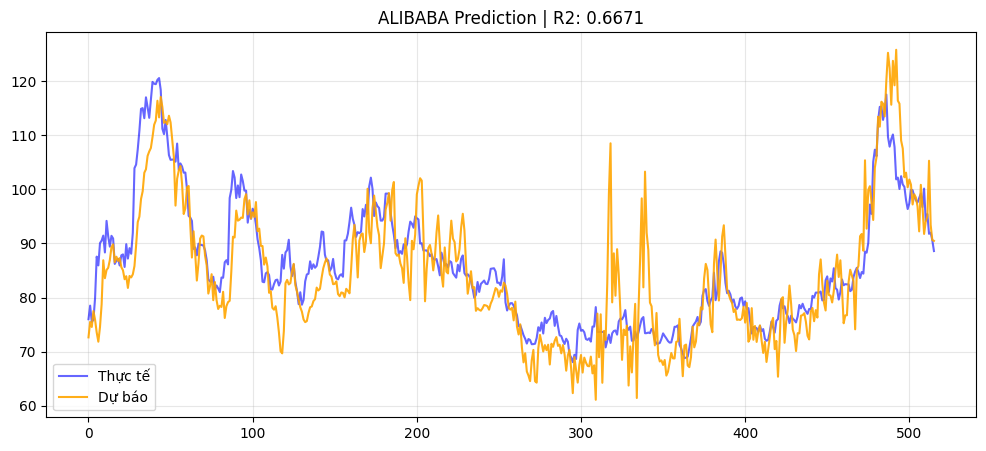

 BỎ QUA: ALIBABA_STOCK_DATA (Không tìm thấy file sentiment)
 BỎ QUA: ALIBABA_STOCK_DATA_ADJ_CLOSE (Không tìm thấy file sentiment)
 BỎ QUA: AMAZON (Không tìm thấy file sentiment)
 BỎ QUA: AMAZON_STOCK_DATA (Không tìm thấy file sentiment)
 BỎ QUA: AMAZON_STOCK_DATA_ADJ_CLOSE (Không tìm thấy file sentiment)

 ĐANG XỬ LÝ: APPLE

 THỐNG KÊ FILE GỐC:
   1. Price     :   2860 dòng | 2013-07-10 -> 2024-11-15
   2. Sentiment :   1020 dòng | 2023-01-11 -> 2025-12-11
   3. SAU MERGE :   3225 dòng (Đã loại bỏ các dòng chỉ có Sentiment)

------------------------------ KIỂM TRA MẪU DỮ LIỆU ------------------------------
 Mẫu dữ liệu CHƯA CÓ TIN TỨC (Price Only):
      Date  Open  High   Low  Close    Volume  sentiment_score  impact_score  relevance_score  confidence  short_term_score  medium_term_score  sentiment_momentum  sentiment_volatility  sentiment_trend  prob_pos  prob_neg intensity_match
2013-07-10 14.99 15.17 14.94  15.03 281405600              NaN           NaN              NaN         NaN

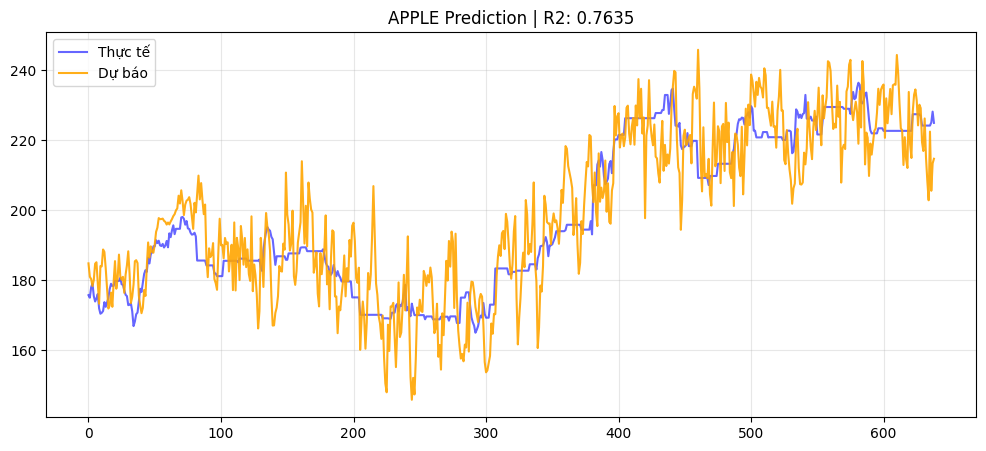

 BỎ QUA: APPLE_STOCK_DATA (Không tìm thấy file sentiment)
 BỎ QUA: APPLE_STOCK_DATA_ADJ_CLOSE (Không tìm thấy file sentiment)
 BỎ QUA: GOOGLE (Không tìm thấy file sentiment)
 BỎ QUA: GOOGLE_STOCK_DATA (Không tìm thấy file sentiment)
 BỎ QUA: GOOGLE_STOCK_DATA_ADJ_CLOSE (Không tìm thấy file sentiment)

 ĐANG XỬ LÝ: META

 THỐNG KÊ FILE GỐC:
   1. Price     :   3204 dòng | 2013-01-02 -> 2025-09-25
   2. Sentiment :    940 dòng | 2020-06-11 -> 2025-03-12
   3. SAU MERGE :   3699 dòng (Đã loại bỏ các dòng chỉ có Sentiment)

------------------------------ KIỂM TRA MẪU DỮ LIỆU ------------------------------
 Mẫu dữ liệu CHƯA CÓ TIN TỨC (Price Only):
      Date  Close  Open  High   Low Volume % Thay đổi  sentiment_score  impact_score  relevance_score  confidence  short_term_score  medium_term_score  sentiment_momentum  sentiment_volatility  sentiment_trend  prob_pos  prob_neg intensity_match
2013-01-02  28.00 27.44 28.18 27.42 69.84M      5.18%              NaN           NaN              NaN 

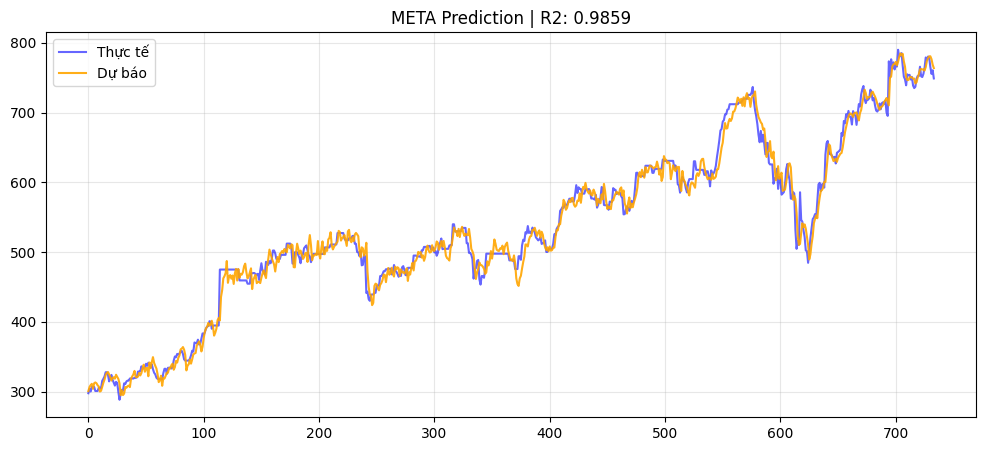

 BỎ QUA: VNM STOCK PRICE HISTORY (Không tìm thấy file sentiment)

 ĐANG XỬ LÝ: VNM

 THỐNG KÊ FILE GỐC:
   1. Price     :   2860 dòng | 2013-07-10 -> 2024-11-15
   2. Sentiment :   2897 dòng | 2021-01-20 -> 2025-12-12
   3. SAU MERGE :   4188 dòng (Đã loại bỏ các dòng chỉ có Sentiment)

------------------------------ KIỂM TRA MẪU DỮ LIỆU ------------------------------
 Mẫu dữ liệu CHƯA CÓ TIN TỨC (Price Only):
      Date  Open  High   Low  Close  Volume  sentiment_score  impact_score  relevance_score  confidence  short_term_score  medium_term_score  sentiment_momentum  sentiment_volatility  sentiment_trend  prob_pos  prob_neg intensity_match
2013-07-10 18.26 18.42 18.25  18.37  185700              NaN           NaN              NaN         NaN               NaN                NaN                 NaN                   NaN              NaN       NaN       NaN             NaN
2013-07-11 18.65 18.82 18.56  18.76  188300              NaN           NaN              NaN         NaN           

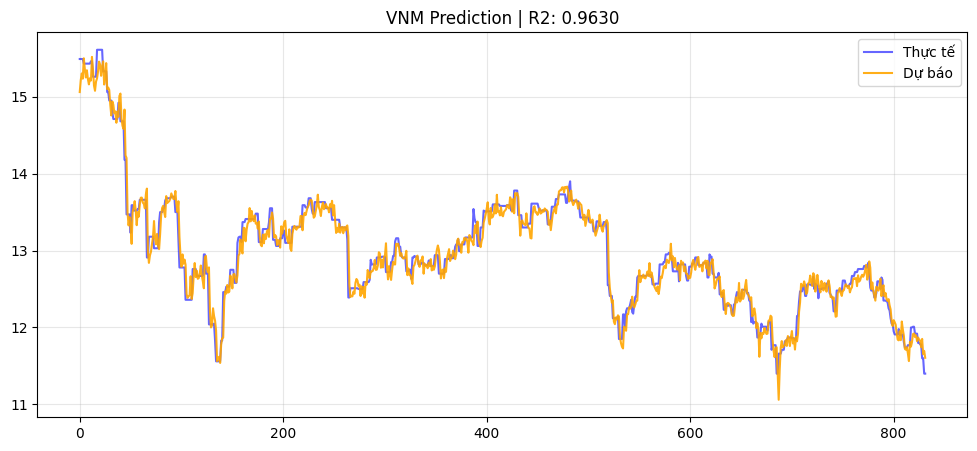

 BỎ QUA: VNM_STOCK_ADJUSTED (Không tìm thấy file sentiment)
 BỎ QUA: VNM_STOCK_ADJUSTED_02 (Không tìm thấy file sentiment)

 HOÀN TẤT TOÀN BỘ.


In [25]:
# =============================================================================
# CHẠY TOÀN BỘ HỆ THỐNG
# =============================================================================

list_price_files = glob.glob(os.path.join(PRICE_DIR, "*.csv"))
print(f" Tìm thấy {len(list_price_files)} file dữ liệu giá.")
print("="*80)

for p_path in list_price_files:
    # 1. Xác định tên mã
    filename = os.path.basename(p_path)
    raw_name = filename.replace(".csv", "")
    stock_name_upper = raw_name.upper()
    
    s_path = os.path.join(SENTIMENT_DIR, f"{stock_name_upper}_sentiment.csv")
    if not os.path.exists(s_path):
        s_path = os.path.join(SENTIMENT_DIR, f"{raw_name}_sentiment.csv")
        if not os.path.exists(s_path):
            print(f" BỎ QUA: {stock_name_upper} (Không tìm thấy file sentiment)")
            continue

    print(f"\n ĐANG XỬ LÝ: {stock_name_upper}")
    
    # 2. Load & Merge Data
    processor = DataProcessor()
    df_merged = processor.load_and_merge_data(p_path, s_path)

    if df_merged is None or len(df_merged) < 200:
        print(" Lỗi: Dữ liệu quá ít.")
        continue

    # --- IN MẪU DỮ LIỆU (ĐÃ LỌC BỎ HEADER/CONTENT) ---
    print("\n" + "-"*30 + " KIỂM TRA MẪU DỮ LIỆU " + "-"*30)
    
    # Xác định các cột cần hiển thị (Loại bỏ Header, Content, Title cho gọn)
    cols_to_hide = ['Header', 'Content', 'Title', 'Header_sentiment', 'Content_sentiment']
    cols_to_show = [c for c in df_merged.columns if c not in cols_to_hide]
    
    # Lấy 5 dòng đầu có NaN ở cột sentiment_score (chưa có tin)
    df_nan = df_merged[df_merged['sentiment_score'].isna()].head(5)
    print(" Mẫu dữ liệu CHƯA CÓ TIN TỨC (Price Only):")
    if not df_nan.empty:
        print(df_nan[cols_to_show].to_string(index=False))
    else:
        print("   (Không có dữ liệu NaN)")

    # Lấy 5 dòng đầu có Dữ liệu Sentiment đầy đủ
    df_data = df_merged[df_merged['sentiment_score'].notna()].head(5)
    print("\n Mẫu dữ liệu CÓ TIN TỨC (Full Data):")
    if not df_data.empty:
        print(df_data[cols_to_show].to_string(index=False))
    else:
        print("   (Không tìm thấy dữ liệu sentiment khớp ngày)")
    print("-" * 80)

    # 3. Feature Engineering & Training
    price_feats, sent_feats, targets = processor.create_features(df_merged)
    X_p, X_s, y = processor.prepare_sequences(price_feats, sent_feats, targets, stock_name_upper, SEQ_LEN)
    
    if len(X_p) == 0: continue

    train_size = int(0.8 * len(X_p))
    train_data = TensorDataset(torch.FloatTensor(X_p[:train_size]), torch.FloatTensor(X_s[:train_size]), torch.FloatTensor(y[:train_size]))
    val_data = TensorDataset(torch.FloatTensor(X_p[train_size:]), torch.FloatTensor(X_s[train_size:]), torch.FloatTensor(y[train_size:]))
    
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    
    model = SentimentDLinearNodeModel(seq_len=SEQ_LEN, price_dim=X_p.shape[2], sentiment_dim=X_s.shape[2], hidden_dim=HIDDEN_DIM, dropout=DROPOUT).to(DEVICE)
    
    history, saved_path = train_model(model, train_loader, val_loader, stock_name_upper, epochs=EPOCHS)
    
    with open(os.path.join(LOG_DIR, f'{stock_name_upper}_training_history.json'), 'w') as f:
        json.dump(history, f, indent=4)

    # 4. Visualize
    model.load_state_dict(torch.load(saved_path, map_location=DEVICE))
    val_start = train_size
    val_p_feats = price_feats.iloc[val_start : val_start + len(y[val_start:]) + SEQ_LEN]
    val_s_feats = sent_feats.iloc[val_start : val_start + len(y[val_start:]) + SEQ_LEN]
    val_targets = targets[val_start : val_start + len(y[val_start:]) + SEQ_LEN]
    
    visualize_prediction(model, processor, val_p_feats, val_s_feats, val_targets, stock_name_upper)
    print("="*80)

print("\n HOÀN TẤT TOÀN BỘ.")